In [37]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
from pyproj import Proj, transform
import time

sinu_proj = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs "
#wgs84_proj = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs "
wgs84_proj = "epsg:4326"
webmerc_proj = "+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs "

modis_pixel_size = (463.312716527916507, 463.312716527916677)
modis_tile = "MCD43A4.A2018001.h%02dv%02d.006_b%d_16"

In [42]:

def ij2xy(origin, i, j):
    x = origin[0] + i * pixel_size[0]
    y = origin[1] + j * pixel_size[1]
    
    return x, y

"""
inProj = Proj(sinu_proj)
outProj = Proj(wgs84_proj)
lon, lat = transform(inProj,outProj,x,y)
print(lon, lat)
"""
    
def xy2ij(origin, x, y):
    i = round((x - origin[0]) / pixel_size[0])
    j = round((y - origin[1]) / pixel_size[1])
    
    return i, j
    
    
def get_partial_tile(bbox, b, h, v, im_size=256, proj=wgs84_proj):
    # bbox contains [min_lon, min_lat, max_lon, max_lat]
    pixel_size = (bbox[2] - bbox[0]) / im_size
    #size = int((bbox[2] - bbox[0]) / pixel_size)
    arr = np.ones((im_size,im_size), dtype=np.float32) * np.nan
    
    start = time.time()
    lons = []
    lats = []
    for j, lat in enumerate(np.arange(bbox[3], bbox[1], -pixel_size)):
        for i, lon in enumerate(np.arange(bbox[0], bbox[2], pixel_size)):
            lons.append(lon)
            lats.append(lat)
    
    inProj = Proj(init=proj)
    outProj = Proj(sinu_proj)
    xs, ys = transform(inProj, outProj, lons, lats)
    print("Transform coordinates", time.time() - start)
    
    start = time.time()
    im = imageio.imread(modis_tile % (h, v, b))
    print("Opening file", time.time() - start)
    
    start = time.time()
    origin = ((h-18)*(modis_pixel_size[0]*2400), (9-v)*(modis_pixel_size[1]*2400))
    for j in range(im_size):
        for i in range(im_size):
            oi, oj = xy2ij(origin, xs[j*im_size+i], ys[j*im_size+i])

            if oi > 2399 or oj > 2399:
                arr[j,i] = 41248
                continue
            if oi < 0 or oj < 0:
                arr[j,i] = 41248
                continue
            arr[j,i] = im[oj,oi]  
    print("Reprojecting", time.time() - start)
            
    return arr


Transform coordinates 0.003968000411987305
Opening file 0.07434797286987305
Reprojecting 0.012603998184204102
Transform coordinates 0.0030062198638916016
Opening file 0.05810403823852539
Reprojecting 0.012112140655517578
Transform coordinates 0.003020763397216797
Opening file 0.09033322334289551
Reprojecting 0.013355016708374023
Transform coordinates 0.0032477378845214844
Opening file 0.061387062072753906
Reprojecting 0.01222991943359375
Transform coordinates 0.0030171871185302734
Opening file 0.06857824325561523
Reprojecting 0.01243281364440918
Transform coordinates 0.004164218902587891
Opening file 0.06444692611694336
Reprojecting 0.012106895446777344
Transform coordinates 0.0031490325927734375
Opening file 0.09938907623291016
Reprojecting 0.01381993293762207
Transform coordinates 0.0032958984375
Opening file 0.06841516494750977
Reprojecting 0.01347208023071289


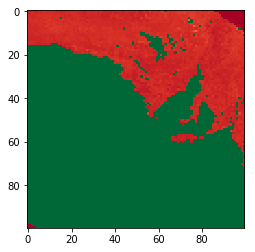

In [43]:


def bbox2tile(bbox, band, im_size, proj):
    pixel_size = (bbox[2] - bbox[0]) / im_size
    modis_x_extent = modis_pixel_size[0]*2400
    modis_y_extent = modis_pixel_size[1]*2400
    inProj = Proj(init=proj)
    outProj = Proj(sinu_proj)
 
    x_tl, y_tl = transform(inProj, outProj, bbox[0], bbox[3])
    x_br, y_br = transform(inProj, outProj, bbox[2], bbox[1])
    
    max_h = int(math.floor(x_tl/modis_x_extent)) + 18
    min_h = int(math.floor(x_br/modis_x_extent)) + 18
    min_v = -1*int(math.ceil(y_tl/modis_y_extent)) + 9
    max_v = -1*int(math.ceil(y_br/modis_y_extent)) + 9
    
    arr = None
    for h in range(min_h, max_h+1):
        for v in range(min_v, max_v+1):
            a = get_partial_tile(bbox, band, h, v, im_size, proj)#.astype(np.float32)
            a[a == 41248] = np.nan
            if arr is None:
                arr = a
                continue
                
            #arr += a
            arr = np.nansum(np.dstack((arr,a)),2)
    
    return arr

b1 = bbox2tile([130., -40., 140., -30], 1, 100, wgs84_proj)
#plt.imshow(b1, cmap='RdYlGn')
b2 = bbox2tile([130., -40., 140., -30], 2, 100, wgs84_proj)
plt.imshow(b2, cmap='RdYlGn')
#plt.imshow(np.clip((b1-b2)/(b1+b2), 0, 1), cmap= 'RdYlGn')

In [41]:
get_tile([130., -40., 140., -30], 29, 12, 0.1)

NameError: name 'get_tile' is not defined